### Intro

In this notebook you can play with a dataset from Section 4 in the original [CappedIGW Paper](https://arxiv.org/abs/2302.08551). 

In the notebook below we define a reference policy and a loss predictor for this dataset. To use CappedIGW this is all you have to define. The rest of the algorithm can be treated as a black box.

Further more CappedIGW is agnostic to the loss predictor function class. This means you can use any loss predictor. In the code provided below we use a Cauchy Network, implemented and optimized with Pytorch.

A quick note, throughout the notebook we use Coba to orchestrate our experiments and record their results. It is not necessary to learn about or use coba to understand and utilize CappedIGW beyond this notebook.

### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install cloudpickle --quiet --quiet

### Define Reference Policy and Loss Predictor

In [2]:
import warnings
from typing import Sequence

import torch
import coba as cb

from AbstractClasses import LossPredictor, ReferencePolicy
from CauchyNetwork import CauchyNetwork

class UniformReferencePolicy(ReferencePolicy):
    def __init__(self, batch_size:int = 100):
        self._batch_size = batch_size
    def sample(self, context):
        while True: yield torch.rand(self._batch_size)

class MyLossPredictor(LossPredictor):
    def __init__(self, *, numrff:int, sigma:float, in_features:int, opt_factory, sched_factory) -> None:
        self._cauchy_net = CauchyNetwork(numrff,sigma,in_features)
        self.loss        = torch.nn.BCEWithLogitsLoss(reduction='none')
        self.opt         = opt_factory(self._cauchy_net.parameters())
        self.scheduler   = sched_factory(self.opt)

    @property
    def params(self):
        return self._cauchy_net.params

    #one context many actions (add more documentation)
    def predict(self, context: torch.Tensor, actions: torch.Tensor) -> Sequence[float]:
        with torch.no_grad():
            context = context.expand(len(actions),-1)
            actions = 100*actions.unsqueeze(1)
            return self._cauchy_net.predictions(torch.cat([context,actions],dim=1)).squeeze(1).tolist()

    #these are triples in parallel arrays (TODO: cleanup documentation)
    def learn(self, contexts: torch.Tensor, actions: Sequence[float], losses: Sequence[float]) -> None:
        with torch.no_grad():
            if contexts.dim() == 1: contexts = contexts.unsqueeze(0)
            actions = 100*torch.tensor(actions).unsqueeze(1)
    
            X = torch.cat([contexts,actions],dim=1)
            y = torch.tensor(losses)

        self.opt.zero_grad()
        yhat = self._cauchy_net.pre_logits(X).squeeze(1)
        loss = self.loss(yhat,y)
        loss.mean().backward()

        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            self.opt.step()
            self.scheduler.step()

        with torch.no_grad():
            optimal_loss = self.loss(torch.logit(y),y)
            cb.CobaContext.learning_info['loss_prediction_loss'] = loss.tolist()
            cb.CobaContext.learning_info['loss_prediction_regret'] = (loss-optimal_loss).tolist()

### Run Demo

This is one of the datasets ("black friday") from section 4.2 of [the paper](https://arxiv.org/abs/2302.08551).  To avoid exhausting your patience, we only use 10% of the data.

2023-07-24 14:36:53 -- Experiment Started
2023-07-24 14:36:53 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-24 14:36:53 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-07-24 14:36:53 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-24 14:36:54 -- Peeking at Environment 0... (0.83 seconds) (completed)
2023-07-24 14:38:30 -- Evaluating Learner 0 on Environment 0... (96.11 seconds) (completed)
2023-07-24 14:38:30 -- Experiment Finished


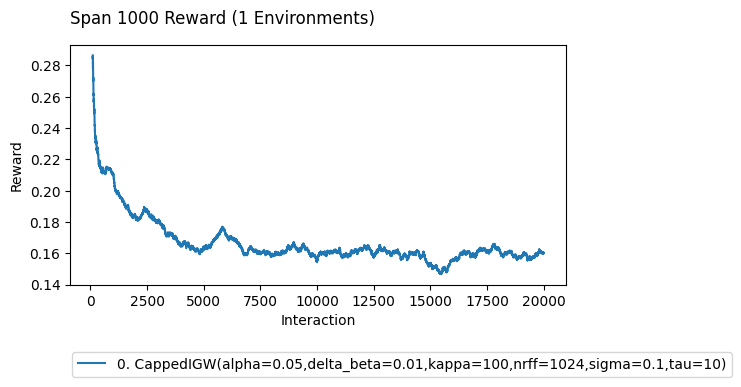

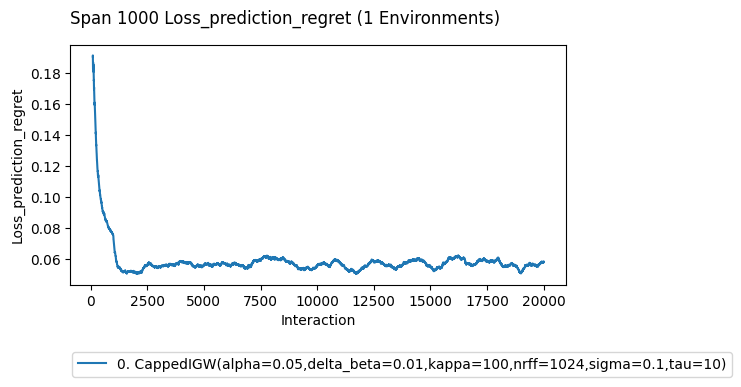

In [3]:
import torch
import coba as cb
from CappedIGW import CappedIGW
from DataCleaning import MakeLosses, Tensorize

#these dimensions are specific to openml dataset 41540
context_dim, action_dim = 22, 1
tzero = 100
sigma = 1e-1
gamma_tzero = 1e-4
lr = 1e-2
batch_size = 8
n_batches = 2_500

fhat = MyLossPredictor(
    numrff=1024,
    sigma=sigma,
    in_features=context_dim+action_dim,
    opt_factory=lambda params: torch.optim.Adam(params,lr=lr),
    sched_factory=lambda opt: torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lambda t:(1+t/tzero)**(-.5))
) 

#this is the directory where the
#openml data will be cached on disk
cb.Environments.cache_dir('.coba_cache')

env = cb.Environments.from_openml(data_id=41540,take=batch_size*n_batches
                                 ).scale("med", "iqr").filter(MakeLosses()).repr('onehot').batch(batch_size).filter(Tensorize())
lrn = CappedIGW(mu=UniformReferencePolicy(), fhat=fhat, gamma_sched=lambda t: (1 + t/gamma_tzero)**(0.5))

result = cb.Experiment(env,lrn).run()
result.plot_learners(y='reward'                , span=1_000, xlim=(100,None))
result.plot_learners(y='loss_prediction_regret', span=1_000, xlim=(100,None))